In [1]:
# --- Imports & config ---------------------------------------------------------
import os, glob, json, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix,
    classification_report
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import joblib

# Plot settings
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

DATA_GLOB = "datamart/gold/model_dataset/gold_model_dataset_*.parquet"
ARTIFACT_DIR = Path("models")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def make_ohe():
    """Compat for scikit-learn versions: sparse_output (>=1.2) vs sparse (older)."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


In [2]:
# --- Load ---------------------------------------------------------------------
paths = sorted(glob.glob(DATA_GLOB))
if not paths:
    raise FileNotFoundError(f"No files found for pattern: {DATA_GLOB}")

df_list = [pd.read_parquet(p) for p in paths]
df = pd.concat(df_list, ignore_index=True)

print("Rows:", len(df), "Cols:", df.shape[1])
display(df.head(3))

# Ensure snapshot_date as datetime
if "snapshot_date" in df.columns:
    df["snapshot_date"] = pd.to_datetime(df["snapshot_date"])
else:
    raise ValueError("Expected 'snapshot_date' column is missing.")

# Ensure target present and int
if "label" not in df.columns:
    raise ValueError("Expected 'label' target column is missing.")
df["label"] = df["label"].astype(int)


Rows: 8974 Cols: 59


,customer_id,snapshot_date,loan_id,label,label_def,interest_rate,num_credit_inquiries,credit_mix,num_of_loan,credit_history_age,...,occ_ENTREPRENEUR,occ_JOURNALIST,occ_LAWYER,occ_MANAGER,occ_MEDIA_MANAGER,occ_MECHANIC,occ_MUSICIAN,occ_SCIENTIST,occ_TEACHER,occ_WRITER
0,CUS_0X16F4,2023-07-01,CUS_0x16f4_2023_01_01,0,30dpd_6mob,6.0,1,Standard,3,362,...,0,0,0,0,1,0,0,0,0,0
1,CUS_0X4340,2023-07-01,CUS_0x4340_2023_01_01,0,30dpd_6mob,22.0,17,Bad,3,153,...,0,0,0,0,0,0,0,0,1,0
2,CUS_0X7C66,2023-07-01,CUS_0x7c66_2023_01_01,0,30dpd_6mob,17.0,6,Bad,8,242,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Shapes & dtypes
print("shape:", df.shape)
display(df.dtypes.to_frame("dtype").head(30))

# Missingness (top 20)
missing = df.isna().mean().sort_values(ascending=False).to_frame("missing_rate")
display(missing.head(20))

# Class balance
print("default rate (overall):", df["label"].mean())
print(df["label"].value_counts(dropna=False).rename({0:"non-default",1:"default"}))


shape: (8974, 59)


,dtype
customer_id,object
snapshot_date,datetime64[ns]
loan_id,object
label,int64
label_def,object
interest_rate,float64
num_credit_inquiries,int32
credit_mix,object
num_of_loan,int32
credit_history_age,int32


,missing_rate
credit_mix,0.211277
minpay_flag,0.119122
invest_to_income,0.044127
emi_to_balance,0.000111
loan_id,0.000000
interest_rate,0.000000
label_def,0.000000
num_credit_inquiries,0.000000
label,0.000000
snapshot_date,0.000000


default rate (overall): 0.28872297749052817
label
non-default    6383
default        2591
Name: count, dtype: int64


Rows per month:


snapshot_date
2023-07-01    530
2023-08-01    501
2023-09-01    506
2023-10-01    510
2023-11-01    521
2023-12-01    517
2024-01-01    471
2024-02-01    481
2024-03-01    454
2024-04-01    487
2024-05-01    491
2024-06-01    489
2024-07-01    485
2024-08-01    518
2024-09-01    511
2024-10-01    513
2024-11-01    491
2024-12-01    498
Freq: MS, dtype: int64


Default rate by month:


snapshot_date
2023-07-01    0.264151
2023-08-01    0.307385
2023-09-01    0.320158
2023-10-01    0.268627
2023-11-01    0.266795
2023-12-01    0.264990
2024-01-01    0.297240
2024-02-01    0.288981
2024-03-01    0.262115
2024-04-01    0.256674
2024-05-01    0.291242
2024-06-01    0.308793
2024-07-01    0.296907
2024-08-01    0.283784
2024-09-01    0.328767
2024-10-01    0.276803
2024-11-01    0.303462
2024-12-01    0.311245
Freq: MS, Name: default_rate, dtype: float64

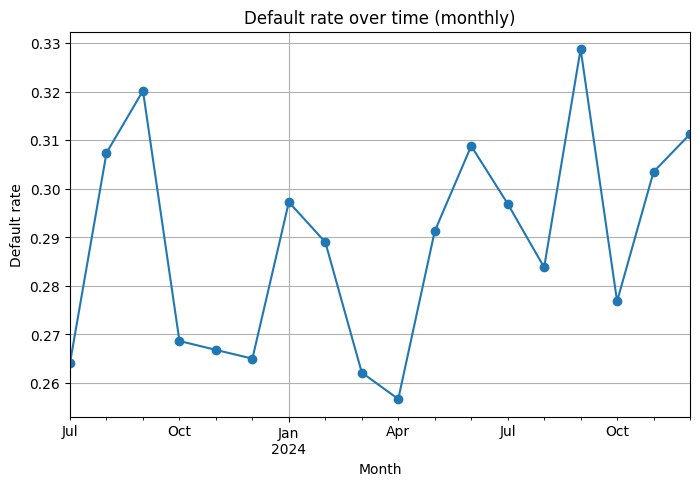

In [5]:
# --- Time coverage & monthly default rate ------------------------------------
by_month_n = (
    df.groupby(df["snapshot_date"].dt.to_period("M"))
      .size()
      .to_timestamp()
)
print("Rows per month:")
display(by_month_n)

by_month_rate = (
    df.groupby(df["snapshot_date"].dt.to_period("M"))["label"]
      .mean()
      .rename("default_rate")
      .to_timestamp()
)
print("\nDefault rate by month:")
display(by_month_rate)

ax = by_month_rate.plot(marker="o", title="Default rate over time (monthly)")
ax.set_xlabel("Month")
ax.set_ylabel("Default rate")
plt.show()


In [6]:
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["label"]]

categorical_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numeric:", len(numeric_cols))
print("Categorical:", len(categorical_cols))
print("Examples numeric:", numeric_cols[:10])
print("Examples categorical:", categorical_cols[:10])


Numeric: 43
Categorical: 14
Examples numeric: ['interest_rate', 'num_credit_inquiries', 'num_of_loan', 'credit_history_age', 'credit_utilization_ratio', 'dti', 'emi_to_income', 'emi_to_balance', 'invest_to_income', 'util_capped']
Examples categorical: ['customer_id', 'loan_id', 'label_def', 'credit_mix', 'util_bucket', 'hist_bucket', 'inq_bucket', 'pay_behav_coarse', 'has_HOME', 'has_AUTO']


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
interest_rate,8974.0,17.509756,16.496597,1.010000,2.000000,3.000000,8.000000,14.000000,22.000000,34.000000,1.000000e+02,1.000000e+02
num_credit_inquiries,8974.0,26.409071,182.934456,0.000000,0.000000,1.000000,4.000000,6.000000,10.000000,14.000000,9.288200e+02,2.554000e+03
num_of_loan,8974.0,3.515489,2.451976,0.000000,0.000000,0.000000,2.000000,3.000000,5.000000,8.000000,9.000000e+00,9.000000e+00
credit_history_age,8974.0,224.643749,99.569536,8.000000,21.000000,69.000000,148.000000,224.000000,304.000000,384.000000,4.000000e+02,4.040000e+02
credit_utilization_ratio,8974.0,32.342112,5.152091,20.100770,22.747996,24.229006,28.054647,32.404043,36.609128,40.231473,4.258364e+01,4.819982e+01
dti,8974.0,0.060395,0.088016,0.000002,0.000161,0.001725,0.009423,0.028101,0.068907,0.246042,4.564766e-01,6.832511e-01
emi_to_income,8974.0,0.607113,4.842670,0.000000,0.000000,0.000000,0.012725,0.025605,0.044463,0.117972,1.815749e+01,1.279216e+02
emi_to_balance,8973.0,7.900891,208.629193,0.000000,0.000000,0.000000,0.087359,0.202311,0.441672,2.478284,1.699513e+02,1.891690e+04
invest_to_income,8578.0,0.051596,0.033367,0.000000,0.000769,0.011084,0.024265,0.043328,0.073472,0.116943,1.393069e-01,1.930707e-01
util_capped,8974.0,32.342112,5.152091,20.100770,22.747996,24.229006,28.054647,32.404043,36.609128,40.231473,4.258364e+01,4.819982e+01


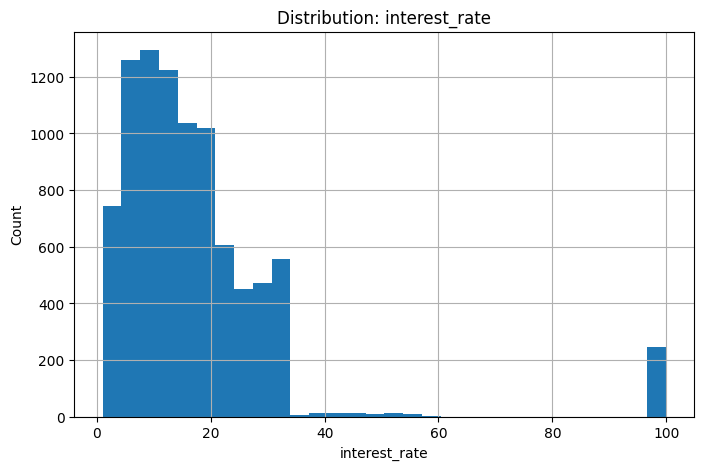

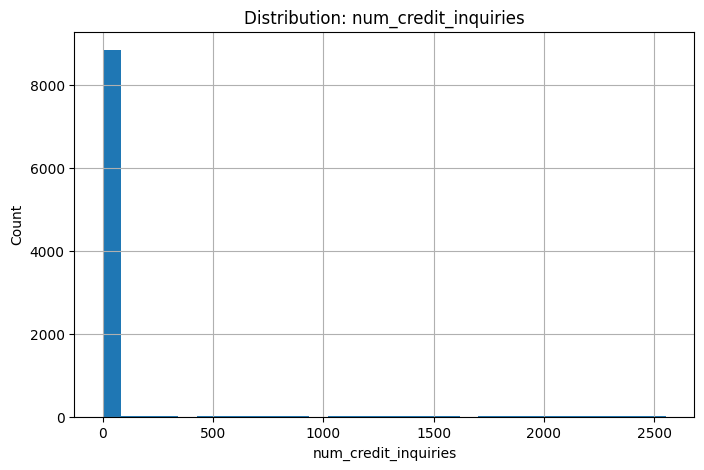

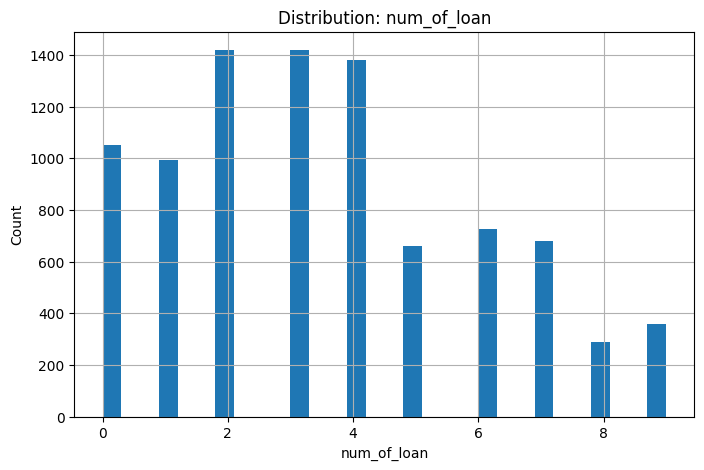

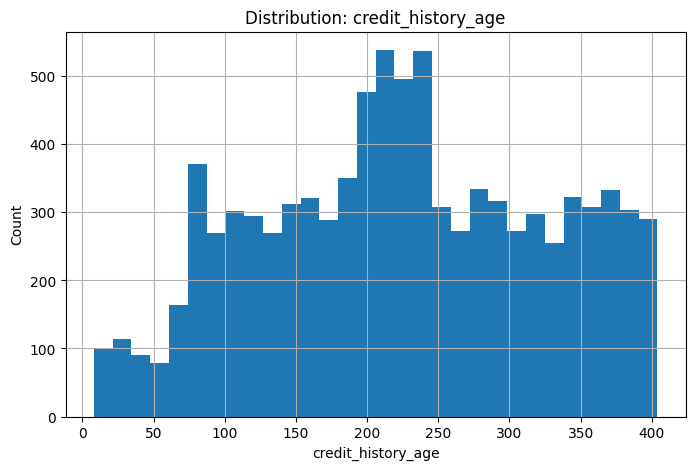

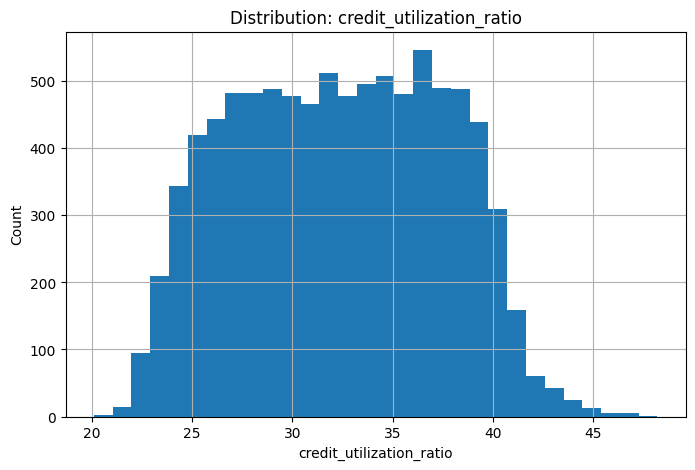

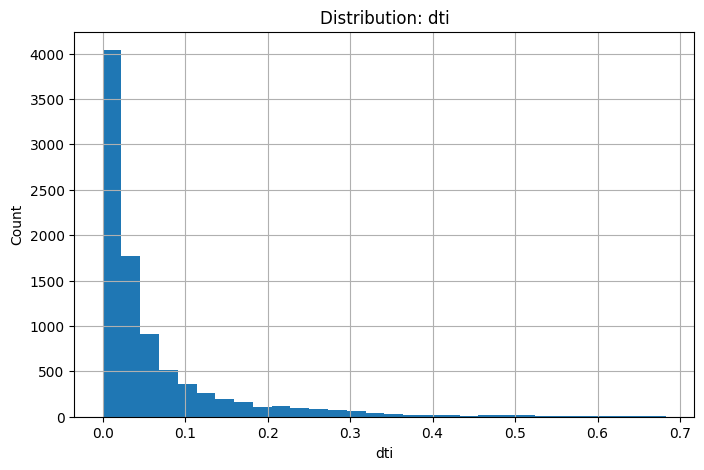

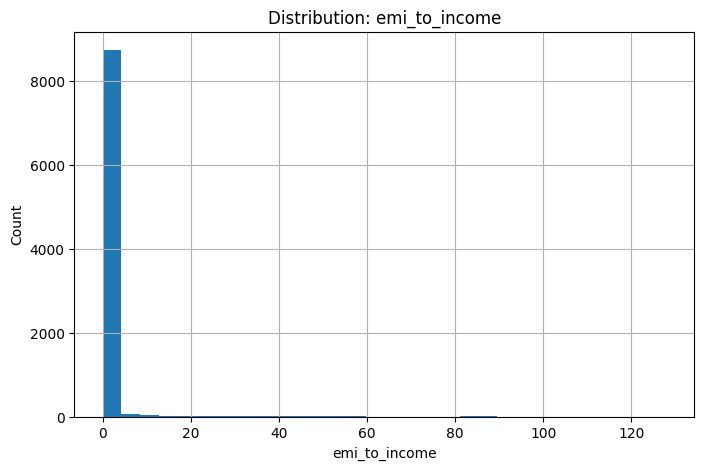

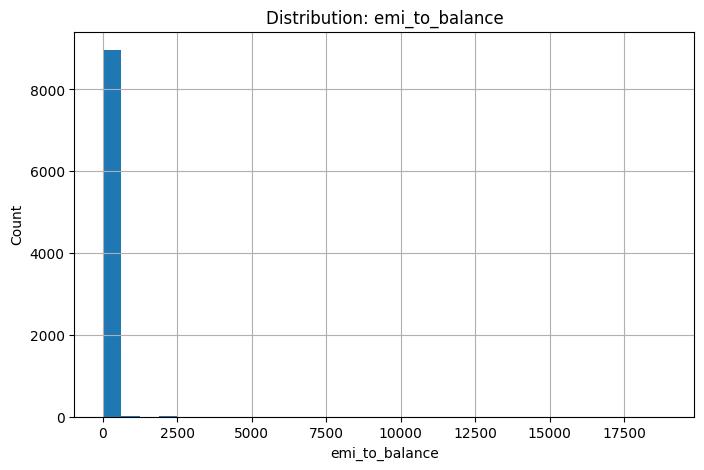

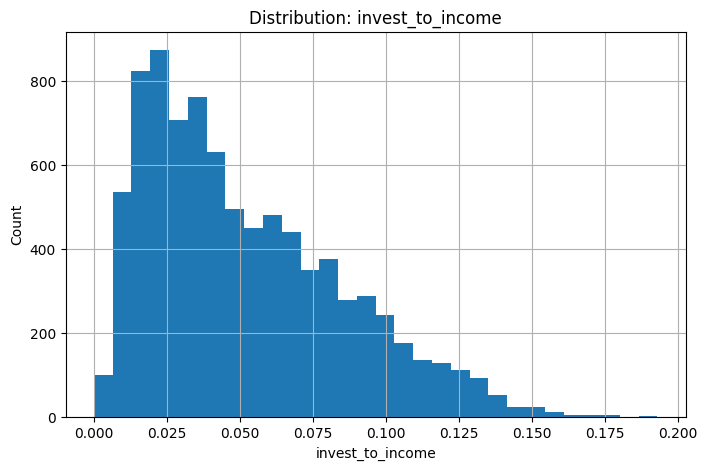

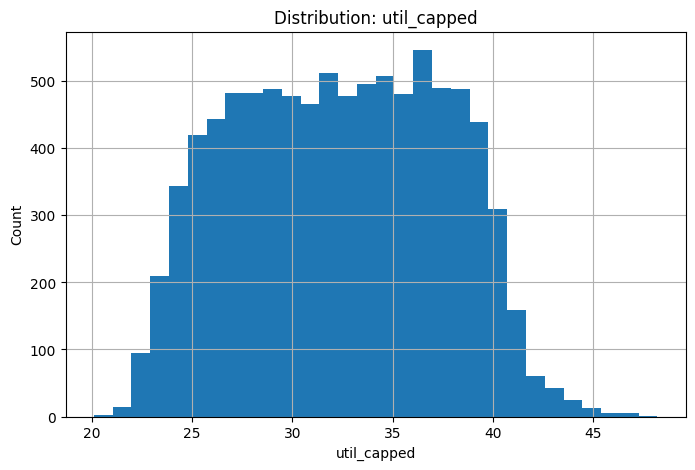

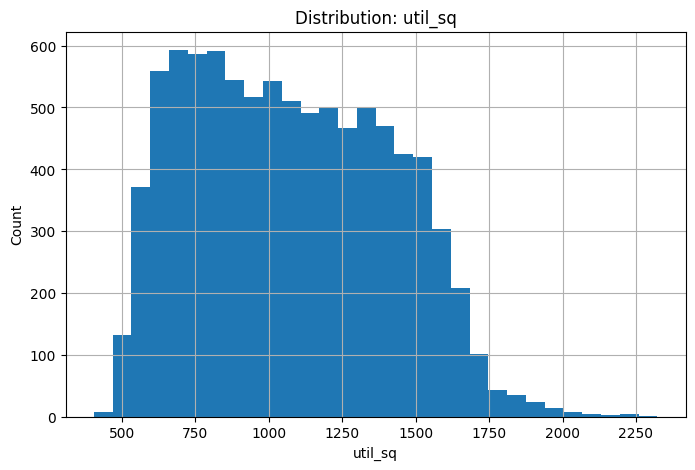

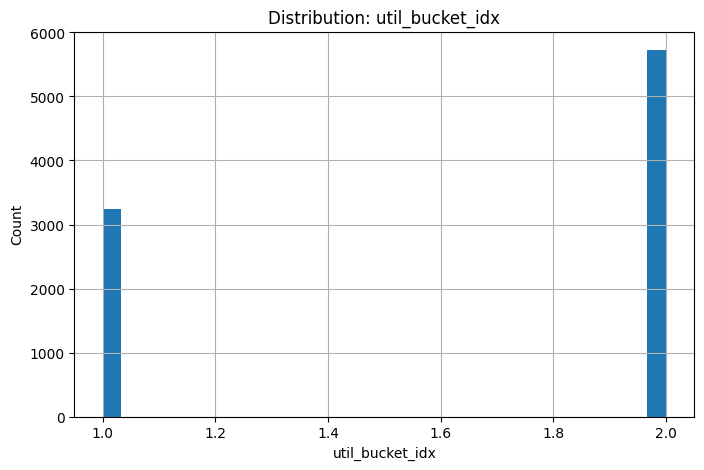

In [7]:
# Summary stats for numeric features
display(df[numeric_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

# Plot first 12 numeric distributions (you can expand to [:20] or more)
for col in numeric_cols[:12]:
    df[col].hist(bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


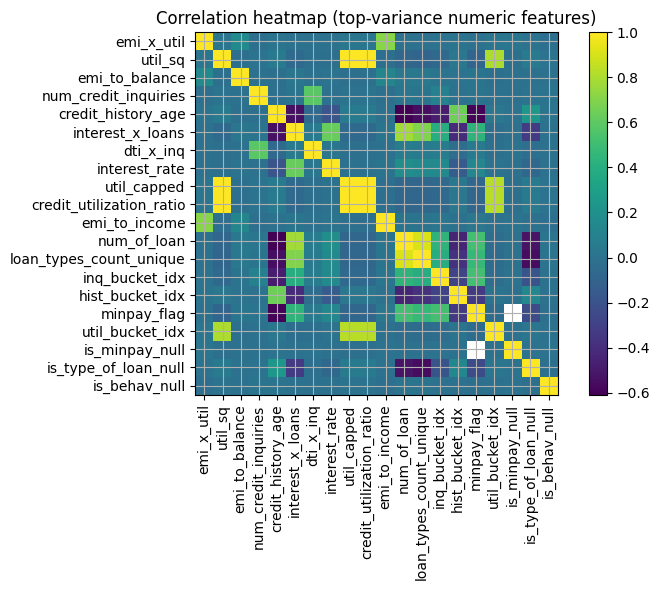

/usr/local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr_with_label
credit_history_age,-0.285381
interest_x_loans,0.284298
num_of_loan,0.277141
minpay_flag,0.267827
loan_types_count_unique,0.251370
dti,0.247753
inq_bucket_idx,0.237834
hist_bucket_idx,-0.149633
interest_rate,0.133552
is_type_of_loan_null,-0.127880


In [8]:
# --- Correlations -------------------------------------------------------------
k = min(20, len(numeric_cols))
topk = df[numeric_cols].var().sort_values(ascending=False).head(k).index.tolist()
corr = df[topk].corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_title("Correlation heatmap (top-variance numeric features)")
ax.set_xticks(range(len(topk))); ax.set_yticks(range(len(topk)))
ax.set_xticklabels(topk, rotation=90); ax.set_yticklabels(topk)
fig.colorbar(im); plt.tight_layout(); plt.show()

# Correlation of each numeric feature with the target
label_corr = df[numeric_cols].corrwith(df["label"]).sort_values(key=np.abs, ascending=False)
display(label_corr.to_frame("corr_with_label").head(20))
